In [12]:
#!/usr/bin/env python3.7
import uproot
import pandas as pd
import os
import ROOT
from ROOT import TF1, TH1, TH1D, TH2D, TFile, gDirectory
import matplotlib.pyplot as plt
import math
import numpy as np
import sklearn
import xgboost as xgb
from hipe4ml.model_handler import ModelHandler
from sklearn.model_selection import train_test_split
from hipe4ml import analysis_utils, plot_utils

In [13]:
suffix = "_K0s_layer5_E158"

In [14]:
multiplicity = (103.0+51.9)/2
BR = 0.6920
eff = 0.068

background_file = ROOT.TFile('Bkg-histos_K0s_TS.root')
hist_ev = background_file.Get('hNevents')
n_ev = hist_ev.GetBinContent(1)

In [15]:
nsig = multiplicity*eff*n_ev*BR
signal_file = uproot.open('fntSig_K0s_TS.root')
df_sig = signal_file["ntcand"].pandas.df()
df_gen = signal_file["ntgen"].pandas.df()
df_sig['tag'] = 1
df_sig['m'] = df_sig['mass']

In [16]:
df_bkg = uproot.open('fntBkg_K0s_TS.root')["ntcand"].pandas.df()
df_bkg['tag'] = 0
df_bkg['m'] = df_bkg['mass']
df = pd.concat([df_sig, df_bkg])

In [17]:
background_file = ROOT.TFile('Bkg-histos_K0s.root')
hist_ev = background_file.Get('hNevents')
n_ev = hist_ev.GetBinContent(1)
nsig = multiplicity*eff*n_ev*BR
signal_file = uproot.open('fntSig_K0s.root')
df_sig = signal_file["ntcand"].pandas.df(entrystop=nsig)
df_bkg = uproot.open('fntBkg_K0s.root')["ntcand"].pandas.df()
df_bkg['m'] = df_bkg['mass']
df_sig['m'] = df_sig['mass']
df_K0s = pd.concat([df_sig, df_bkg])

In [18]:
COLUMNS = ['dist','cosp','dca','y']
train_set, test_set, y_train, y_test = train_test_split(df[COLUMNS + ['m']], df['tag'], test_size=0.5, random_state=42)
data = [train_set, y_train, test_set, y_test]

In [19]:
HYPERPARAMS_RANGE = {
  "max_depth": [5, 20], # defines the maximum depth of a single tree (regularization)
  "learning_rate": [0.01, 0.3], # learning rate
  "n_estimators": [50, 500], # number of boosting trees
  "gamma": [0.3, 1.1], # specifies the minimum loss reduction required to make a split
  "min_child_weight": [1, 12],
  "subsample": [0.5, 0.9], # denotes the fraction of observations to be randomly samples for each tree
  "colsample_bytree": [0.5, 0.9]
}

In [20]:
HYPERPARAMS_VALUES = {
    'max_depth': 7.11386337462144,
    'learning_rate': 0.16738186411589207,
    'n_estimators': 83.54778965589688,
    'gamma': 0.5247476077499046,
    'min_child_weight': 9.824166788294436,
    'subsample': 0.8947547746402069,
    'colsample_bytree': 0.6427013306774357,
    'seed': 42
}

In [ ]:
HYPERPARAMS_VALUES = {
    'max_depth': 7,
    'learning_rate': 0.167,
    'n_estimators': 83,
    'gamma': 0.525,
    'min_child_weight': 9.82,
    'subsample': 0.89,
    'colsample_bytree': 0.64,
    'seed' : 42
}

In [35]:
input_model = xgb.XGBClassifier()
model_handler = ModelHandler(input_model)
model_handler.set_training_columns(COLUMNS)
#model_handler.set_model_params(HYPERPARAMS_VALUES)
#model_handler.optimize_params_bayes(data, HYPERPARAMS_RANGE, 'roc_auc', init_points=10, n_iter=10)
model_handler.train_test_model(data)

Number of detected classes: 2
[15:34:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training the final model: Done!
Testing the model: Done!
ROC_AUC_score: 0.996588


In [ ]:
model_handler.dump_model_handler("bdt_model_layer5_E158.pkl")

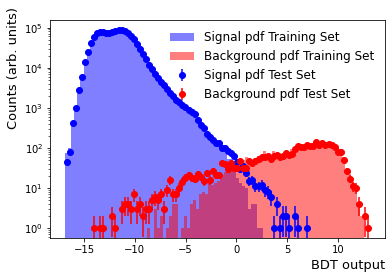

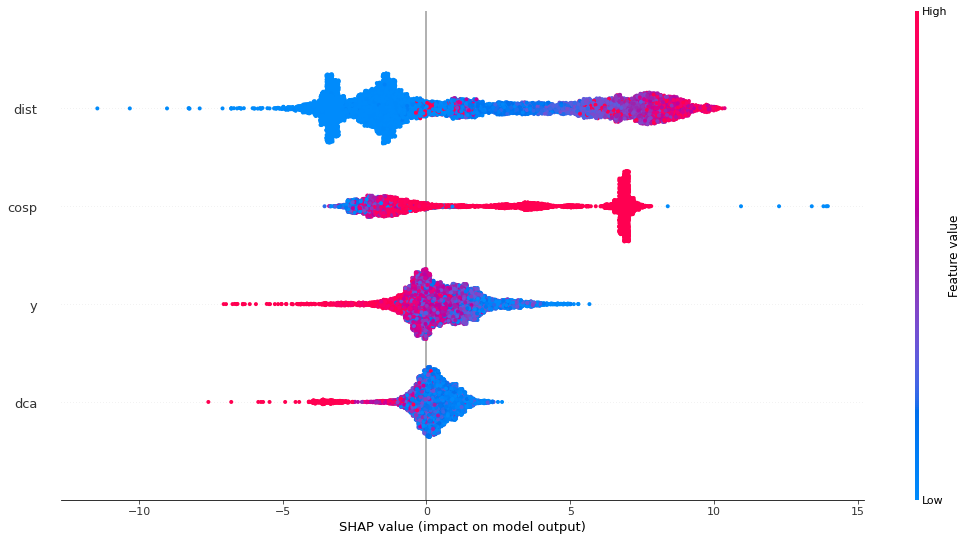

In [26]:
bdt_score_dir = 'TrainTest'
if not os.path.exists(bdt_score_dir):
    os.makedirs(bdt_score_dir)
bdt_score_plot = plot_utils.plot_output_train_test(model_handler, data, bins=100, log=True)
bdt_score_plot.savefig(bdt_score_dir+'/BDT_Score.pdf')

feat_imp = plot_utils.plot_feature_imp(data[2][model_handler.get_original_model().get_booster().feature_names], data[3], model_handler)
plt.savefig(bdt_score_dir + '/FeatImp.pdf')
plt.close()

In [36]:
def fit_hist(
        histo, cent_class, pt_range, ct_range, nsigma=3, model="pol2", fixsigma=-1, sigma_limits=None, mode=2, split =''):
    # canvas for plotting the invariant mass distribution
    cv = ROOT.TCanvas(f'cv_{histo.GetName()}')
    
    mass_min = mass*0.97
    mass_max = mass*1.03
    # define the number of parameters depending on the bkg model
    if 'pol' in str(model):
        n_bkgpars = int(model[3]) + 1
    elif 'expo' in str(model):
        n_bkgpars = 2
    else:
        print(f'Unsupported model {model}')

    # define the fit function bkg_model + gauss
    fit_tpl = TF1('fitTpl', f'{model}(0)+gausn({n_bkgpars})', 0, 5)

    # redefine parameter names for the bkg_model
    for i in range(n_bkgpars):
        fit_tpl.SetParName(i, f'B_{i}')

    # define parameter names for the signal fit
    fit_tpl.SetParName(n_bkgpars, 'N_{sig}')
    fit_tpl.SetParName(n_bkgpars + 1, '#mu')
    fit_tpl.SetParName(n_bkgpars + 2, '#sigma')
    # define parameter values and limits
    #fit_tpl.SetParameter(n_bkgpars, 40)
    #fit_tpl.SetParLimits(n_bkgpars, 0.001, 10000)
    fit_tpl.SetParameter(n_bkgpars + 1, mass)
    fit_tpl.SetParLimits(n_bkgpars + 1, 0.495, 0.5)

    # define signal and bkg_model TF1 separately
    sigTpl = TF1('fitTpl', 'gausn(0)', 0, 5)
    bkg_tpl = TF1('fitTpl', f'{model}(0)', 0, 5)

    # plotting stuff for fit_tpl
    fit_tpl.SetNpx(300)
    fit_tpl.SetLineWidth(2)
    fit_tpl.SetLineColor(2)
    # plotting stuff for bkg model
    bkg_tpl.SetNpx(300)
    bkg_tpl.SetLineWidth(2)
    bkg_tpl.SetLineStyle(2)
    bkg_tpl.SetLineColor(2)

    # define limits for the sigma if provided
    if sigma_limits != None:
        fit_tpl.SetParameter(n_bkgpars + 2, 0.5 *
                             (sigma_limits[0] + sigma_limits[1]))
        fit_tpl.SetParLimits(n_bkgpars + 2, sigma_limits[0], sigma_limits[1])
    # if the mc sigma is provided set the sigma to that value
    elif fixsigma > 0:
        fit_tpl.FixParameter(n_bkgpars + 2, fixsigma)
    # otherwise set sigma limits reasonably
    else:
        fit_tpl.SetParameter(n_bkgpars + 2, 0.002)
        fit_tpl.SetParLimits(n_bkgpars + 2, 0.001, 0.003)

    ########################################
    # plotting the fits
    if mode == 2:
        ax_titles = ';m (#pi^{+} + #pi^{-}) (GeV/#it{c})^{2};Counts' + f' / {round(1000 * histo.GetBinWidth(1), 2)} MeV'
    if mode == 3:
        ax_titles = ';m (d + p + #pi) (GeV/#it{c})^{2};Counts' + f' / {round(1000 * histo.GetBinWidth(1), 2)} MeV'

    # invariant mass distribution histo and fit
    histo.UseCurrentStyle()
    histo.SetLineColor(1)
    histo.SetMarkerStyle(20)
    histo.SetMarkerColor(1)
    histo.SetTitle(ax_titles)
    histo.SetMaximum(1.5 * histo.GetMaximum())
    histo.Fit(fit_tpl, "QRL", "", mass_min, mass_max)
    histo.Fit(fit_tpl, "QRL", "", mass_min, mass_max)
    histo.SetDrawOption("e")
    histo.GetXaxis().SetRangeUser(mass_min, mass_max)
    # represent the bkg_model separately
    bkg_tpl.SetParameters(fit_tpl.GetParameters())
    bkg_tpl.SetLineColor(600)
    bkg_tpl.SetLineStyle(2)
    bkg_tpl.Draw("same")
    # represent the signal model separately
    sigTpl.SetParameter(0, fit_tpl.GetParameter(n_bkgpars))
    sigTpl.SetParameter(1, fit_tpl.GetParameter(n_bkgpars+1))
    sigTpl.SetParameter(2, fit_tpl.GetParameter(n_bkgpars+2))
    sigTpl.SetLineColor(600)
    # sigTpl.Draw("same")

    # get the fit parameters
    mu = fit_tpl.GetParameter(n_bkgpars+1)
    muErr = fit_tpl.GetParError(n_bkgpars+1)
    sigma = fit_tpl.GetParameter(n_bkgpars+2)
    sigmaErr = fit_tpl.GetParError(n_bkgpars+2)
    signal = fit_tpl.GetParameter(n_bkgpars) / histo.GetBinWidth(1)
    errsignal = fit_tpl.GetParError(n_bkgpars) / histo.GetBinWidth(1)
    bkg = bkg_tpl.Integral(mu - nsigma * sigma, mu +
                           nsigma * sigma) / histo.GetBinWidth(1)

    if bkg > 0:
        errbkg = math.sqrt(bkg)
    else:
        errbkg = 0
    # compute the significance
    if signal+bkg > 0:
        signif = signal/math.sqrt(signal+bkg)
        deriv_sig = 1/math.sqrt(signal+bkg)-signif/(2*(signal+bkg))
        deriv_bkg = -signal/(2*(math.pow(signal+bkg, 1.5)))
        errsignif = math.sqrt((errsignal*deriv_sig)**2+(errbkg*deriv_bkg)**2)
    else:
        signif = 0
        errsignif = 0

    # print fit info on the canvas
    pinfo2 = ROOT.TPaveText(0.5, 0.5, 0.91, 0.9, "NDC")
    pinfo2.SetBorderSize(0)
    pinfo2.SetFillStyle(0)
    pinfo2.SetTextAlign(30+3)
    pinfo2.SetTextFont(42)

    string = 'Pb-Pb, #sqrt{s_{NN}} = 17.3 GeV, '+f'centrality {cent_class[0]}-{cent_class[1]}%'
    pinfo2.AddText(string)

    string = ' %i #leq #it{ct} < %i cm %i #leq #it{p}_{T} < %i GeV/#it{c} ' % (
        ct_range[0], ct_range[1], pt_range[0], pt_range[1])
    #pinfo2.AddText(string)

    string = f'Significance ({nsigma:.0f}#sigma) {signif:.1f} #pm {errsignif:.1f} '
    pinfo2.AddText(string)

    string = f'S ({nsigma:.0f}#sigma) {signal:.0f} #pm {errsignal:.0f}'
    pinfo2.AddText(string)

    string = f'B ({nsigma:.0f}#sigma) {bkg:.0f} #pm {errbkg:.0f}'
    pinfo2.AddText(string)

    if bkg > 0:
        ratio = signal/bkg
        string = f'S/B ({nsigma:.0f}#sigma) {ratio:.4f}'

    pinfo2.AddText(string)
    pinfo2.Draw()
    ROOT.gStyle.SetOptStat(0)

    st = histo.FindObject('stats')
    if isinstance(st, ROOT.TPaveStats):
        st.SetX1NDC(0.12)
        st.SetY1NDC(0.62)
        st.SetX2NDC(0.40)
        st.SetY2NDC(0.90)
        st.SetOptStat(0)

    histo.Write()
    cv.Write()

    return (signal, errsignal, signif, errsignif, mu, muErr, sigma, sigmaErr)
    return (signal, errsignal, signif, errsignif, sigma, sigmaErr)


In [37]:
if 'score' in data[2].columns:
    print("score already exists")
else:
    y_pred = model_handler.predict(data[2])
    data[2].insert(0, 'score', y_pred)

In [38]:
if 'score' in df_K0s.columns:
    print("score already exists")
else:
    y_pred = model_handler.predict(df_K0s)
    df_K0s.insert(0, 'score', y_pred)

In [39]:
if 'tag' in data[2].columns:
    print("tag already exists")
else:
    data[2].insert(0, 'tag', data[3])

In [40]:
efficiencies, threshold = analysis_utils.bdt_efficiency_array(data[3],data[2]['score'])

In [41]:
hist_bdt_eff = ROOT.TH1D("hist_bdt_eff",";score selection;BDT efficiency",len(threshold)-1,threshold[0],threshold[len(threshold)-1])
for index in range(0,len(threshold)):
    hist_bdt_eff.SetBinContent(index+1,efficiencies[index])
cv = ROOT.TCanvas("cv","cv")
hist_bdt_eff.SetLineColor(ROOT.kRed)
hist_bdt_eff.Draw("c")
cv.SaveAs("TrainTest/bdt_eff"+suffix+".png")
cv.SaveAs("TrainTest/bdt_eff"+suffix+".pdf")

Info in <TCanvas::Print>: png file TrainTest/bdt_eff_K0s_layer5_E158.png has been created
Info in <TCanvas::Print>: pdf file TrainTest/bdt_eff_K0s_layer5_E158.pdf has been created


In [42]:
pdg_code = 310
mass = ROOT.TDatabasePDG.Instance().GetParticle(pdg_code).Mass()
mass_min = mass*0.97
mass_max = mass*1.03
nbin = 40
output = ROOT.TFile("BDTresults.root","RECREATE")
score_list = np.arange(-15,5,0.1) 
for sel in score_list:
    counts, _ = np.histogram(df_K0s.query('score > @sel')['m'], nbin, range=[mass_min,mass_max])
    hist = TH1D(f'hist_score_{sel:.1f}', ';m_{\pi^{+}\pi^{-}} (GeV/c^{2});counts', nbin, mass_min, mass_max)

    for index in range(0, nbin):
        hist.SetBinContent(index + 1, counts[index])
    
    fit_hist(hist,[0,5],[0,10],[0,100])
    #hist.Write()
output.Close()

In [43]:
pdg_code = 310
mass = ROOT.TDatabasePDG.Instance().GetParticle(pdg_code).Mass()
mass_min = mass*0.97
mass_max = mass*1.03
nbin = 40
output = ROOT.TFile("mass_shaping.root","RECREATE")
score_list = np.arange(-15,5,0.1) 
for sel in score_list:
    counts, _ = np.histogram(data[2].query('score > @sel and tag < 0.5')['m'], nbin, range=[mass_min,mass_max])
    hist = TH1D(f'hist_score_{sel:.1f}', ';m_{\pi^{+}\pi^{-}} (GeV/c^{2});counts', nbin, mass_min, mass_max)

    for index in range(0, nbin):
        hist.SetBinContent(index + 1, counts[index])
    
    fit_hist(hist,[0,5],[0,10],[0,100])
    #hist.Write()
output.Close()

In [44]:
def significance_error(signal, background):
    signal_error = np.sqrt(signal + 1e-10)
    background_error = np.sqrt(background + 1e-10)

    sb = signal + background + 1e-10
    sb_sqrt = np.sqrt(sb)

    s_propag = (sb_sqrt + signal / (2 * sb_sqrt))/sb * signal_error
    b_propag = signal / (2 * sb_sqrt)/sb * background_error

    if signal+background == 0:
        return 0

    return np.sqrt(s_propag * s_propag + b_propag * b_propag)

In [50]:
def significance_scan(df, threshold_space, pre_selection_efficiency = 0.068, nevents = 50, mass_bins=40, sigma=0.001):
    print('\nSignificance scan: ...')
    multiplicity = (103.0+51.9)/2
    BR = 0.6920
    eff = 0.068
    Tslope = 0.2289
    mass = ROOT.TDatabasePDG.Instance().GetParticle(pdg_code).Mass()
    mass_min = mass*0.97
    mass_max = mass*1.03    
    hist_sig =  ROOT.TH1D("hist_sig",";score selection;significance",len(threshold_space),threshold_space[0],threshold_space[len(threshold_space)-1])
    hist_sig3 =  ROOT.TH1D("hist_sig3",";score selection;significance",len(threshold_space),threshold_space[0],threshold_space[len(threshold_space)-1])
    hist_sig2 =  ROOT.TH1D("hist_sig2",";score selection;significance",len(threshold_space),threshold_space[0],threshold_space[len(threshold_space)-1])
    hist_bkg =  ROOT.TH1D("hist_bkg",";mass;counts", mass_bins, mass_min, mass_max)
    fBkg = ROOT.TF1("fBkg","[0]",mass_min,mass_max)
    bw = ROOT.TF1("fpt","x*exp(-TMath::Sqrt(x**2+[0]**2)/[1])",0,10)
    bw.SetParameter(0,mass)
    bw.SetParameter(1,Tslope)
    sig_max = -1
    for index, tsd in enumerate(threshold_space):
        print(index)

        df_bkg = df.query('score>@tsd and tag < 0.5')
        counts_bkg, bins = np.histogram(df_bkg['m'], bins=mass_bins, range=[mass_min, mass_max])
        
        counts_gen, bins = np.histogram(df.query('tag > 0.5')['m'], bins=mass_bins, range=[mass_min, mass_max])
        counts_sig, bins = np.histogram(df.query('score > @tsd and tag > 0.5')['m'], bins=mass_bins, range=[mass_min, mass_max])
        bdt_eff = sum(counts_sig)/sum(counts_gen)
        for index in range(0, mass_bins):
            hist_bkg.SetBinContent(index+1,counts_bkg[index])
            hist_bkg.SetBinError(index+1,math.sqrt(counts_bkg[index]))
        hist_bkg.Fit(fBkg,"QMR+")
        exp_background = fBkg.Integral(mass-3*sigma,mass+3*sigma)/hist_bkg.GetBinWidth(1)
        exp_signal = multiplicity*BR*eff*nevents*bdt_eff
        
        if (exp_background < 0):
            exp_background = 0
            
        sig = exp_signal / np.sqrt(exp_signal + exp_background + 1e-10)
        hist_sig.SetBinContent(index+1,sig)
        hist_sig3.SetBinContent(index+1,sig)
        hist_sig.SetBinError(index+1,significance_error(exp_signal,exp_background))
        hist_sig2.SetBinContent(index+1,sig)
        hist_sig2.SetBinError(index+1,0)
        if sig > sig_max:
            sig_max = sig
            score_max = tsd
        print("sig: ",sig," score: ",tsd)
        print("sig: ",hist_sig.GetBinContent(index+1)," score: ",tsd)
    cv = ROOT.TCanvas("cv","cv")
    legend = ROOT.TLegend(0.4,0.2,0.7,0.4)
    hist_sig.SetLineColor(ROOT.kWhite)
    hist_sig.SetFillColor(7)
    hist_sig.SetFillStyle(4050)
    hist3_sig.Draw()
    cv.SaveAs("significance_scanpre.png")
    hist_sig.Draw("E4")
    
    hist_sig2.Draw("C same")
    legend.AddEntry(hist_sig2,"Expected significance","l")
    legend.AddEntry(hist_sig,"#pm 1#sigma","f")
    legend.Draw()
    cv.SaveAs("significance_scan.png")
    cv.SaveAs("significance_scan.pdf")
    
    return  score_max

In [51]:
print(significance_scan(data[2],score_list))


Significance scan: ...
0
sig:  1.3281421001023832  score:  -15.0
sig:  1.3281421001023832  score:  -15.0
1
sig:  1.3303072722265405  score:  -14.9
sig:  1.3303072722265405  score:  -14.9
2
sig:  1.3334859159024393  score:  -14.8
sig:  1.3334859159024393  score:  -14.8
3
sig:  1.3367750961370923  score:  -14.700000000000001
sig:  1.3367750961370923  score:  -14.700000000000001
4
sig:  1.3407200645023791  score:  -14.600000000000001
sig:  1.3407200645023791  score:  -14.600000000000001
5
sig:  1.3457429003891535  score:  -14.500000000000002
sig:  1.3457429003891535  score:  -14.500000000000002
6
sig:  1.3516571417241598  score:  -14.400000000000002
sig:  1.3516571417241598  score:  -14.400000000000002
7
sig:  1.359075554941973  score:  -14.300000000000002
sig:  1.359075554941973  score:  -14.300000000000002
8
sig:  1.3675017258347686  score:  -14.200000000000003
sig:  1.3675017258347686  score:  -14.200000000000003
9
sig:  1.3773547503191677  score:  -14.100000000000003
sig:  1.37735475

sig:  11.251277021224057  score:  -7.200000000000028
sig:  11.251277021224057  score:  -7.200000000000028
79
sig:  11.43524907214316  score:  -7.100000000000028
sig:  11.43524907214316  score:  -7.100000000000028
80
sig:  11.577347308332232  score:  -7.000000000000028
sig:  11.577347308332232  score:  -7.000000000000028
81
sig:  11.881010112375575  score:  -6.900000000000029
sig:  11.881010112375575  score:  -6.900000000000029
82
sig:  11.984073519954528  score:  -6.800000000000029
sig:  11.984073519954528  score:  -6.800000000000029
83
sig:  12.08302670091107  score:  -6.7000000000000295
sig:  12.08302670091107  score:  -6.7000000000000295
84
sig:  12.14697405858221  score:  -6.60000000000003
sig:  12.14697405858221  score:  -6.60000000000003
85
sig:  12.175808668449323  score:  -6.50000000000003
sig:  12.175808668449323  score:  -6.50000000000003
86
sig:  12.309590584160684  score:  -6.4000000000000306
sig:  12.309590584160684  score:  -6.4000000000000306
87
sig:  12.406985818013577 

sig:  11.85324030244278  score:  0.7999999999999439
sig:  11.85324030244278  score:  0.7999999999999439
159
sig:  11.828557085238327  score:  0.8999999999999435
sig:  11.828557085238327  score:  0.8999999999999435
160
sig:  11.801571630602151  score:  0.9999999999999432
sig:  11.801571630602151  score:  0.9999999999999432
161
sig:  11.776781173438485  score:  1.0999999999999446
sig:  11.776781173438485  score:  1.0999999999999446
162
sig:  11.75193893509575  score:  1.1999999999999424
sig:  11.75193893509575  score:  1.1999999999999424
163
sig:  11.715711669326923  score:  1.2999999999999403
sig:  11.715711669326923  score:  1.2999999999999403
164
sig:  11.683921590781  score:  1.3999999999999417
sig:  11.683921590781  score:  1.3999999999999417
165
sig:  11.645203862082498  score:  1.4999999999999432
sig:  11.645203862082498  score:  1.4999999999999432
166
sig:  11.617796806565506  score:  1.599999999999941
sig:  11.617796806565506  score:  1.599999999999941
167
sig:  11.5880334344899

NameError: name 'hist3_sig' is not defined

  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 1 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 1 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 1 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 1 VARIABLE PARAMET

Warning in <TROOT::Append>: Replacing existing TH1: hist_sig (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_sig3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_sig2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_bkg (Potential memory leak).
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit dat

In [52]:
score_list

array([-1.50000000e+01, -1.49000000e+01, -1.48000000e+01, -1.47000000e+01,
       -1.46000000e+01, -1.45000000e+01, -1.44000000e+01, -1.43000000e+01,
       -1.42000000e+01, -1.41000000e+01, -1.40000000e+01, -1.39000000e+01,
       -1.38000000e+01, -1.37000000e+01, -1.36000000e+01, -1.35000000e+01,
       -1.34000000e+01, -1.33000000e+01, -1.32000000e+01, -1.31000000e+01,
       -1.30000000e+01, -1.29000000e+01, -1.28000000e+01, -1.27000000e+01,
       -1.26000000e+01, -1.25000000e+01, -1.24000000e+01, -1.23000000e+01,
       -1.22000000e+01, -1.21000000e+01, -1.20000000e+01, -1.19000000e+01,
       -1.18000000e+01, -1.17000000e+01, -1.16000000e+01, -1.15000000e+01,
       -1.14000000e+01, -1.13000000e+01, -1.12000000e+01, -1.11000000e+01,
       -1.10000000e+01, -1.09000000e+01, -1.08000000e+01, -1.07000000e+01,
       -1.06000000e+01, -1.05000000e+01, -1.04000000e+01, -1.03000000e+01,
       -1.02000000e+01, -1.01000000e+01, -1.00000000e+01, -9.90000000e+00,
       -9.80000000e+00, -

In [ ]:
ROOT.gStyle.SetOptStat(0)
cv = ROOT.TCanvas("cv","cv")
legend = ROOT.TLegend(0.8,0.8,1,1)
counter = 0
nbin = 50
min_val = -50
max_val = 50
df = data[2].query('y > 0.5')
counts1, _ = np.histogram(df['score'], nbin, range=[min_val,max_val])
hist1 = TH1D('hist_score_1', ';score;pdf', nbin, min_val, max_val)
df = data[2].query('y < 0.5')
counts2, _ = np.histogram(df['score'], nbin, range=[min_val,max_val])
hist2 = TH1D('hist_score_2', ';score;pdf', nbin, min_val, max_val)
for index in range(0, nbin):
    hist1.SetBinContent(index + 1, counts1[index])
    hist2.SetBinContent(index + 1, counts2[index])
    
hist1.Scale(1./sum(counts1))
hist2.Scale(1./sum(counts2))
hist2.SetFillColor(ROOT.kBlue)
legend.AddEntry(hist2,'background',"f")
hist2.Draw("same hist")
hist1.SetFillColor(ROOT.kRed)    
legend.AddEntry(hist1,'signal',"f")
hist1.Draw("same hist")


legend.Draw()
cv.SaveAs("score.png")

In [31]:
def plot_corr(data_list, columns, labels=None, **kwds):
    """
    Calculate pairwise correlation between features for
    each class (e.g. signal and background in case of binary
    classification)
    Parameters
    -----------------------------------------------
    data_list: list
        Contains dataframes for each class
    columns: list
        Contains the name of the features you want to plot
        Example: ['dEdx', 'pT', 'ct']
    labels: list
        Contains the labels to be displayed in the legend
        If None the labels are class1, class2, ..., classN
    **kwds: extra arguments are passed on to DataFrame.corr()
    Returns
    ------------------------------------------------
    out: matplotlib.figure.Figure or list of them
        Correlations between the features for each class
    """
    list_of_df = []
    if isinstance(data_list[0], hipe4ml.tree_handler.TreeHandler):
        for handl in data_list:
            list_of_df.append(handl.get_data_frame())
    else:
        list_of_df = data_list
    corr_mat = []
    for dfm in list_of_df:
        dfm = dfm[columns]
        corr_mat.append(dfm.corr(**kwds))

    if labels is None:
        labels = []
        if len(corr_mat) != 2:
            for i_mat, _ in enumerate(corr_mat):
                labels.append(f'class{i_mat}')
        else:
            labels.append('Signal')
            labels.append('Background')

    res = []
    for mat, lab in zip(corr_mat, labels):
        if len(corr_mat) < 2:
            res = plt.figure(figsize=(8, 7))
            grid = ImageGrid(res, 111, axes_pad=0.15, nrows_ncols=(1, 1), share_all=True,
                             cbar_location='right', cbar_mode='single', cbar_size='7%', cbar_pad=0.15)
        else:
            res.append(plt.figure(figsize=(8, 7)))
            grid = ImageGrid(res[-1], 111, axes_pad=0.15, nrows_ncols=(1, 1), share_all=True,
                             cbar_location='right', cbar_mode='single', cbar_size='7%', cbar_pad=0.15)

        opts = {'cmap': plt.get_cmap(
            'coolwarm'), 'vmin': -1, 'vmax': +1, 'snap': True}

        axs = grid[0]
        heatmap = axs.pcolor(mat, **opts)
        axs.set_title(lab, fontsize=14, fontweight='bold')

        lab = mat.columns.values

        # shift location of ticks to center of the bins
        axs.set_xticks(np.arange(len(lab)), minor=False)
        axs.set_yticks(np.arange(len(lab)), minor=False)
        axs.set_xticklabels(lab, minor=False, ha='left',
                            rotation=90, fontsize=10)
        axs.set_yticklabels(lab, minor=False, va='bottom', fontsize=10)
        axs.tick_params(axis='both', which='both', direction="in")

        for tick in axs.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')

        plt.colorbar(heatmap, axs.cax)

    return res

In [32]:
def plot_corr(df, columns):
    bdt_score_dir = 'TrainTest'
    #corr_columns = COLUMNS+['m']
    data_sig = df.query("tag > 0.5")[columns]
    data_bkg = df.query("tag < 0.5")[columns]
    correlations = data_sig.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(columns),1)
    plt.title('Signal')
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(columns)
    ax.set_yticklabels(columns)
    plt.show()
    plt.savefig(bdt_score_dir + '/CorrelationMatrixSignal.pdf')
    plt.close()
    
    correlations = data_bkg.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(columns),1)
    plt.title('Background')
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(columns)
    ax.set_yticklabels(columns)
    plt.show()
    plt.savefig(bdt_score_dir + '/CorrelationMatrix.pdf')
    plt.close()

In [33]:
bdt_score_dir = 'TrainTest'
corr_columns = COLUMNS+['m']
plot_corr(data[2], corr_columns)

UndefinedVariableError: name 'tag' is not defined